### Classify a review as positive or negative using Spark.

We have a dataset containing review of movies, each review is labeled as "positive" or "negative". In this notebook we will analyze this data and attempt to train a model to classify a review as "positive" or "negative".

# Data Loading and Cleaning

In [202]:
import os
import pandas as pd

#Setting up the main directories that contain the data
train_dir = os.getcwd() + "/aclImdb/train/"
test_dir = os.getcwd() + "/aclImdb/test/"

In [206]:
#Take a look at one review

target_dir = train_dir + "pos"

for file in os.listdir(target_dir)[:1]:
    open_file = open(target_dir + '/' + file, 'r')
    line_list = open_file.readlines()
    print(line_list)

['For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.']


In [225]:
#Function to load data in a pandas dataframe

def get_data(data_dir):
    reviews = []
    labels = []
    for directory in os.listdir(data_dir)[1:]:
        target_dir = data_dir + directory
        for file in os.listdir(target_dir):
            opened = open(target_dir + '/' + file, 'r')
            reviews.append(opened.readlines()[0])
            labels.append(directory)
    return pd.DataFrame({"Reviews": reviews, "Labels": labels})

In [226]:
#Load data
train_df = get_data(train_dir)
test_df = get_data(test_dir)

train_df.head()

,Reviews,Labels
0,Working with one of the best Shakespeare sourc...,neg
1,"Well...tremors I, the original started off in ...",neg
2,Ouch! This one was a bit painful to sit throug...,neg
3,"I've seen some crappy movies in my life, but t...",neg
4,"""Carriers"" follows the exploits of two guys an...",neg


In [227]:
#Convert categorical labels to integers

train_df["Labels"] = train_df["Labels"].map({"neg": 0, "pos": 1})
test_df["Labels"] = test_df["Labels"].map({"neg": 0, "pos": 1})

#Shuffle the datasets
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

train_df.head()

,Reviews,Labels
24006,"This is, by all categories, the best movie I h...",1
7934,I saw this movie when I was really little. It ...,0
13139,This is by far one of my favorite of the Ameri...,1
3582,I was looking on Imdbs bottom 100 because i th...,0
6617,"I'm just quite disappointed with ""Soul Survivo...",0


In [214]:
from pyspark.sql import SparkSession

In [228]:
#Create spark session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

In [229]:
spark.sparkContext.setLogLevel("OFF")

In [230]:
#Convert the dataframe to a spark dataframe
train_df_spark = spark.createDataFrame(train_df)
test_df_spark = spark.createDataFrame(test_df)
train_df_spark.printSchema()
train_df_spark.show()

root
 |-- Reviews: string (nullable = true)
 |-- Labels: long (nullable = true)



+--------------------+------+
|             Reviews|Labels|
+--------------------+------+
|This is, by all c...|     1|
|I saw this movie ...|     0|
|This is by far on...|     1|
|I was looking on ...|     0|
|I'm just quite di...|     0|
|Greetings again f...|     1|
|So, this movie ha...|     0|
|Renown writer Mar...|     0|
|Another variation...|     0|
|I have looked for...|     1|
|Just saw the movi...|     0|
|This film is a jo...|     1|
|This film is the ...|     0|
|Artimisia was on ...|     1|
|Wonderful family ...|     1|
|- SMALL SPOILER H...|     1|
|The movie itself ...|     1|
|The original show...|     0|
|What a wasted cas...|     0|
|"Hitler, the rise...|     1|
+--------------------+------+
only showing top 20 rows



In [231]:
from pyspark.ml.feature import RegexTokenizer, Word2Vec
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

In [232]:
#Regular expression tokenizer

regexTokenizer = RegexTokenizer(inputCol="Reviews", outputCol="Words", pattern="\W")

word2Vec = Word2Vec(vectorSize=20,inputCol="Words", outputCol="Features")
     

In [233]:
pipe = Pipeline(stages=[regexTokenizer, word2Vec])

#Fit the pipeline and transform the data

fitted_pipe_train = pipe.fit(train_df_spark)
fitted_pipe_test = pipe.fit(test_df_spark)

df_train = fitted_pipe.transform(train_df_spark)
df_test = fitted_pipe.transform(test_df_spark)

In [234]:
df_train.show()
df_test.show()

+--------------------+------+--------------------+--------------------+
|             Reviews|Labels|               Words|            Features|
+--------------------+------+--------------------+--------------------+
|This is, by all c...|     1|[this, is, by, al...|[-0.0534475129422...|
|I saw this movie ...|     0|[i, saw, this, mo...|[-0.0875566846122...|
|This is by far on...|     1|[this, is, by, fa...|[-0.0813220515088...|
|I was looking on ...|     0|[i, was, looking,...|[-0.0826543765771...|
|I'm just quite di...|     0|[i, m, just, quit...|[-0.0625450603401...|
|Greetings again f...|     1|[greetings, again...|[-0.0430543737529...|
|So, this movie ha...|     0|[so, this, movie,...|[-0.0816953717588...|
|Renown writer Mar...|     0|[renown, writer, ...|[-0.0719920042913...|
|Another variation...|     0|[another, variati...|[-0.0925688853321...|
|I have looked for...|     1|[i, have, looked,...|[-0.0229801038178...|
|Just saw the movi...|     0|[just, saw, the, ...|[-0.1102866693

In [235]:
#Create and fit a logistic regression model
logistic_reg = LogisticRegression(featuresCol='Features', labelCol='Labels', maxIter=10)

lr_fit = logistic_reg.fit(df_train)

#Get predictions
preds = lr_fit.transform(df_test)
preds.show(10)

+--------------------+------+--------------------+--------------------+--------------------+--------------------+----------+
|             Reviews|Labels|               Words|            Features|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+--------------------+--------------------+----------+
|I have seen chees...|     0|[i, have, seen, c...|[-0.1103554659147...|[1.98756888035946...|[0.87948569932601...|       0.0|
|Blake Edwards tri...|     0|[blake, edwards, ...|[-0.0862969321237...|[0.19742466795112...|[0.54919647848391...|       0.0|
|This is a magnifi...|     1|[this, is, a, mag...|[-0.1007283014137...|[-0.8432594319228...|[0.30084875435074...|       1.0|
|I saw this movie ...|     0|[i, saw, this, mo...|[-0.0712505594345...|[1.10962673198969...|[0.75205951619537...|       0.0|
|I would be intere...|     1|[i, would, be, in...|[-0.1023515172371...|[-0.2549104015477...|[0.43661525325260...|       1.0|


Train area under ROC: 0.84768048


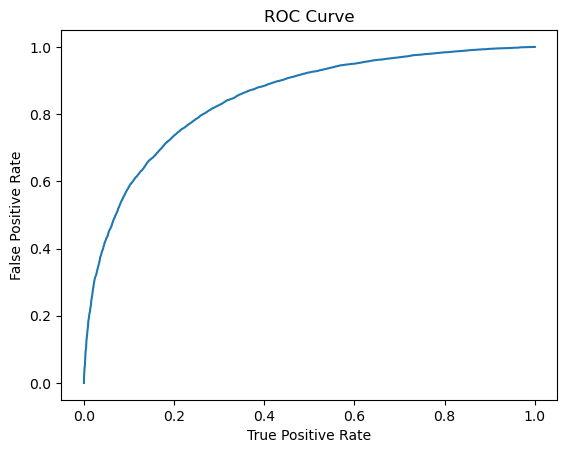

In [236]:
import matplotlib.pyplot as plt

#Plotting the ROC Curve
summary = lr_fit.summary
print(f"Train area under ROC: {summary.areaUnderROC}")
roc_df = summary.roc.toPandas()
plt.plot(roc_df["FPR"], roc_df["TPR"])
plt.ylabel("False Positive Rate")
plt.xlabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [237]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#Evaluate the test area under the ROC curve
evaluator = BinaryClassificationEvaluator(
                labelCol="Labels", 
                rawPredictionCol="rawPrediction", 
                metricName="areaUnderROC")

auc = evaluator.evaluate(preds)

print ("Test area under ROC curve:", auc)


Test area under ROC curve: 0.8250787679999999


### Try parameter tuning and 5-fold cross validation to try to get better performance

In [238]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

grid = ParamGridBuilder().addGrid(lr_fit.maxIter, [0, 1]).build()
evaluator = BinaryClassificationEvaluator(labelCol="Labels",
                                         rawPredictionCol="rawPrediction",
                                         metricName="areaUnderROC")
cv = CrossValidator(estimator=logistic_reg,evaluator=evaluator, estimatorParamMaps=grid, numFolds=5)
cvModel = cv.fit(df_train)

In [239]:
best_model = cvModel.bestModel
trainingSummary = best_model.summary

In [244]:
print(f"Accuracy from 5-fold cross validation: {evaluator.evaluate(cvModel.transform(df_train))}")

Accuracy from 5-fold cross validation: 0.746803904


### Random Forest Model

In [246]:
from pyspark.ml.classification import RandomForestClassifier

#Create and fit a random forest model
random_forest = RandomForestClassifier(featuresCol='Features', labelCol='Labels')

random_forest_fitted = random_forest.fit(df_train)
preds = random_forest_fitted.transform(df_test)
preds.show(5)

+--------------------+------+--------------------+--------------------+--------------------+--------------------+----------+
|             Reviews|Labels|               Words|            Features|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+--------------------+--------------------+----------+
|I have seen chees...|     0|[i, have, seen, c...|[-0.1103554659147...|[14.4837893853435...|[0.72418946926717...|       0.0|
|Blake Edwards tri...|     0|[blake, edwards, ...|[-0.0862969321237...|[11.6586909995332...|[0.58293454997666...|       0.0|
|This is a magnifi...|     1|[this, is, a, mag...|[-0.1007283014137...|[9.12136380708154...|[0.45606819035407...|       1.0|
|I saw this movie ...|     0|[i, saw, this, mo...|[-0.0712505594345...|[14.6004194715787...|[0.73002097357893...|       0.0|
|I would be intere...|     1|[i, would, be, in...|[-0.1023515172371...|[9.68494782815157...|[0.48424739140757...|       1.0|


Training area under ROC: 0.8103824288


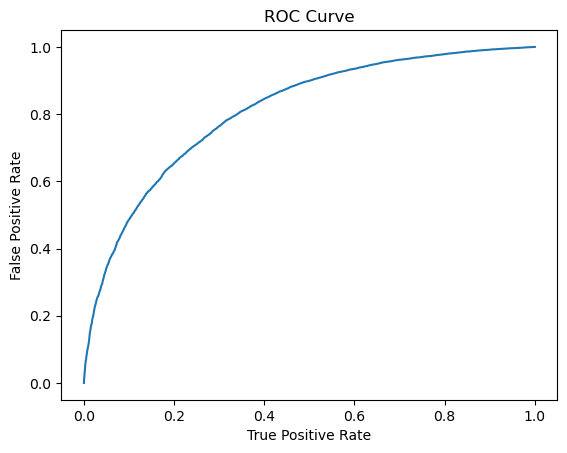

In [247]:
#Plot the ROC curve from training data
train_summary = random_forest_fitted.summary
print(f"Training area under ROC: {train_summary.areaUnderROC}")
roc_df = train_summary.roc.toPandas()
plt.plot(roc_df["FPR"], roc_df["TPR"])
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve")
plt.show()

In [248]:
evaluator = BinaryClassificationEvaluator(
                labelCol="Labels", 
                rawPredictionCol="rawPrediction", 
                metricName="areaUnderROC")

auc = evaluator.evaluate(preds)

print ("Test area under ROC:", auc)


Test area under ROC: 0.7772492608000001


#### As can be seen, the ranodm forest does worse on the training data

### XGBoost Model

In [249]:
from xgboost.spark import SparkXGBClassifier

In [256]:
#Create and fit XGBoost classifier
xgb_clf = SparkXGBClassifier(features_col="Features",
                            label_col="Labels")

xgb_fitted = xgb_clf.fit(df_train)
preds = xgb_fitted.transform(df_test)
preds.show()

[22:37:16] task 0 got new rank 0                                    (0 + 1) / 1]


+--------------------+------+--------------------+--------------------+--------------------+----------+--------------------+
|             Reviews|Labels|               Words|            Features|       rawPrediction|prediction|         probability|
+--------------------+------+--------------------+--------------------+--------------------+----------+--------------------+
|I have seen chees...|     0|[i, have, seen, c...|[-0.1103554659147...|[2.62772679328918...|       0.0|[0.93262487649917...|
|Blake Edwards tri...|     0|[blake, edwards, ...|[-0.0862969321237...|[1.43411040306091...|       0.0|[0.80754095315933...|
|This is a magnifi...|     1|[this, is, a, mag...|[-0.1007283014137...|[-2.0876135826110...|       1.0|[0.11030656099319...|
|I saw this movie ...|     0|[i, saw, this, mo...|[-0.0712505594345...|[1.88192629814147...|       0.0|[0.86783224344253...|
|I would be intere...|     1|[i, would, be, in...|[-0.1023515172371...|[-0.0850469619035...|       1.0|[0.47875106334686...|


In [262]:
#Evaluate the test area under ROC
xgb_evaluator = BinaryClassificationEvaluator(labelCol="Labels",
                                             rawPredictionCol="rawPrediction",
                                             metricName="areaUnderROC")

auc = xgb_evaluator.evaluate(preds)

print(f"Test Area under ROC curve: {auc}")

Test Area under ROC curve: 0.8192983360000001


#### XGBoost does better than random forest but Logistic Regression still outperforms both of them.